In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from math import *
import sys
from skimage import io
from time import clock,time
import pandas as pd
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
from scipy.linalg import eig
from scipy.linalg import leslie


# 1. Leslie Matrix approach

In [49]:
# data source:
# http://math.harvard.edu/archive/21b_summer_05/supplements/popgrowth.pdf
# canadian female population 1965
# age intervals
age_upper = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
]
# birth rates
a = [
    0,
    0.00024,
    0.05861,
    0.28608,
    0.44791,
    0.36399,
    0.22259,
    0.10457,
    0.02826,
    0.00240
]
# death rates
b = [
    0.99651,
    0.99820,
    0.99802,
    0.99729,
    0.99694,
    0.99621,
    0.99460,
    0.99184,
    0.98700
]

leslie_mat = leslie(a,b)
np.round(leslie_mat,2)

array([[ 0.  ,  0.  ,  0.06,  0.29,  0.45,  0.36,  0.22,  0.1 ,  0.03,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.99,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.99,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.99,  0.  ]])

**Population Projection**

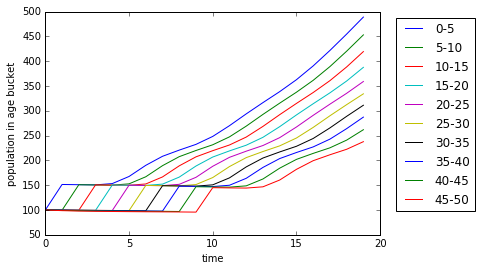

In [50]:
# plot projections for next 20 years
P = [np.ones(len(age_upper))*100]
tToPlot = range(20)
for _ in range(1,20):
    P.append(np.dot(leslie_mat,P[-1]))

for age_itvl in range(len(age_upper)):
    plt.plot(tToPlot, [Pt[age_itvl] for Pt in P], label=str(age_upper[age_itvl]-5)+'-'+str(age_upper[age_itvl]))
plt.legend(bbox_to_anchor=(1.3, 1))
plt.ylabel('population in age bucket')
plt.xlabel('time')

**Condition number**

In [51]:
np.linalg.cond(leslie_mat)

615.76107195293503

**Eigenvalue analysis**

* The dominant eigenvalue yields long-term growth rate.
* The associated eigenvector gives long-term age composition.

In [52]:
lambda1 = max(eig(leslie_mat)[0])
x1_unnorm = abs(eig(leslie_mat)[1][:,np.argmax(lambda1)])
x1 = x1_unnorm/max(x1_unnorm)

print "long term growth rate: %0.6f" % lambda1
print "long term composition: ", np.round(x1, 3)

long term growth rate: 1.076219
long term composition:  [ 1.     0.926  0.859  0.796  0.738  0.684  0.633  0.585  0.539  0.494]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: ComplexWarning: Casting complex values to real discards the imaginary part


* population increases by 7.622% every 5 years.
* for every 100,000 females between 0-5, there will be 92,594 in 5-10.

# 2. Compartmental Approach

In [53]:
# http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S1794-91652014000100003
# From Sara's code
# ANALYITCAL SOLUTION
b = 0.01270
mu = 0.00799
beta = 1/22.0
gamma = 1/43.0
x0 = 1000000
y0 = 1000000
z0 = 1000000

def C(t):
    return (b + np.exp(-1*beta*t)*(-1*b + beta*x0)) / beta

def W(t):
    return ( (b*np.exp(gamma*t)/gamma) + 
        ((-1*b + beta*x0)*np.exp(gamma*t - beta*t)/(gamma - beta)) -
        ((b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta)/(gamma*(-1*gamma + beta))) ) * np.exp(-1*gamma*t)

def R(t):
    t1 = (-1*b*t + (np.exp(-1*beta*t)*(-1*b + beta*x0))/beta ) * (gamma/(-1*gamma + beta))
    t2 =  -1 * (np.exp(-1*gamma*t)*(b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta) / (gamma*(-1*gamma + beta))) * (gamma/(-1*gamma + beta))
    t3 = (b*t + (b*beta  - gamma*beta*x0 - y0*gamma*beta - z0*gamma*beta + gamma*b)/(gamma*beta)) * (gamma/(-1*gamma + beta))
    t4 = (np.exp(-1*gamma*t)*(b*beta - gamma*beta*x0 + y0*gamma**2 - y0*gamma*beta) / (gamma*(-1*gamma + beta)) + b*t) * (beta/(-1*gamma + beta))
    t5 = ((-b*beta + gamma*beta*x0 + y0*gamma*beta + z0*gamma*beta - gamma*b)/(gamma*beta) - b*t) * (beta/(-1*gamma + beta))
    return t1 + t2 + t3 + t4 + t5


times = np.linspace(0,100,100)
c = [C(t) for t in times]
w = [W(t) for t in times]
r = [R(t) for t in times]


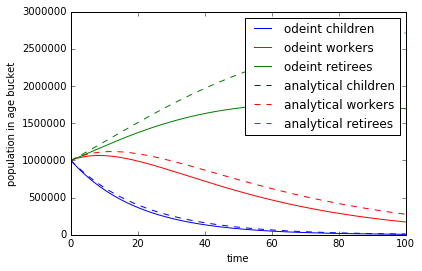

In [54]:
# ODE APPROACH
b = 0.01270
mu = 0.00799
beta = 1/22.0
gamma = 1/43.0
x0 = 1000000
y0 = 1000000
z0 = 1000000

def pop_path(path,t):
    C,W,R = path
    ## I couldn't get the exact scaled approach to work
    #     scale=float(C+W+R)
    #     c = C/scale
    #     w = W/scale
    #     r = R/scale
    dcdt = b - beta*C - (b-mu)*C
    dwdt = beta*C - gamma*W - (b-mu)*W
    drdt = gamma*W - mu - (b-mu)*R
    
    ## vanilla approach
    #     P=float(C+W+R)
    #     dcdt = b*P - beta*C
    #     dwdt = beta*C - gamma*W
    #     drdt = gamma*W - P*mu
    return [dcdt, dwdt, drdt]
    
path0 = [1000000]*3

t = np.linspace(0,100,800)
path_out = odeint(pop_path, path0, t)

plt.plot(t,path_out[:,0],label='odeint children', color="blue")
plt.plot(t,path_out[:,1],label='odeint workers', color="red")
plt.plot(t,path_out[:,2],label='odeint retirees', color="green")
plt.plot(times,c, color="blue", label="analytical children", ls='--')
plt.plot(times,w, color="red", label="analytical workers", ls='--')
plt.plot(times,r, color="green", label="analytical retirees", ls='--')
plt.legend()
plt.ylabel('population in age bucket')
plt.xlabel('time')

# 3. The problem with the vanilla compartmental and Leslie approach is that we wish to enforce an upper bound on population indicative of resource limits. Motivates Verhulst:

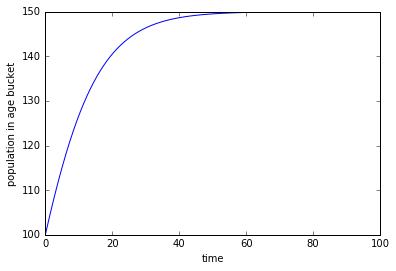

In [55]:
# http://www.diva-portal.org/smash/get/diva2:20614/FULLTEXT01.pdf
# http://tutorial.math.lamar.edu/Classes/DE/Modeling.aspx
def pop_path(path,t):
    P = path[0]
    r = 0.1
    K = 150 # THIS PARAMETER GOVERNS POP MAX
    dPdt = r*P*(1-P/K)
    return [dPdt]

P0 = [100]

t = np.linspace(0,100,800)
path_out = odeint(pop_path, P0, t)
plt.plot(t, path_out)
plt.ylabel('population in age bucket')
plt.xlabel('time')

In [1]:
np.randn.choice(range(8))

NameError: name 'np' is not defined